<a href="https://colab.research.google.com/github/Ibnuamrithaher/Deep-Learning/blob/main/14%20-%20Convolutional%20Neural%20Network/Part%203%20-%20CNN%20with%20PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install -v "luwiji==1.1.1"
!pip install -v "jcopdl==1.1.1"

Using pip 24.1.2 from /usr/local/lib/python3.11/dist-packages/pip (python 3.11)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 MB 7.2 MB/s eta 0:00:00
  Running command python setup.py egg_info
  running egg_info
  creating /tmp/pip-pip-egg-info-a0k254s4/luwiji.egg-info
  writing /tmp/pip-pip-egg-info-a0k254s4/luwiji.egg-info/PKG-INFO
  writing dependency_links to /tmp/pip-pip-egg-info-a0k254s4/luwiji.egg-info/dependency_links.txt
  writing requirements to /tmp/pip-pip-egg-info-a0k254s4/luwiji.egg-info/requires.txt
  writing top-level names to /tmp/pip-pip-egg-info-a0k254s4/luwiji.egg-info/top_level.txt
  writing manifest file '/tmp/pip-pip-egg-info-a0k254s4/luwiji.egg-info/SOURCES.txt'
  reading manifest file '/tmp/pip-pip-egg-info-a0k254s4/luwiji.egg-info/SOURCES.txt'
  reading manifest template 'MANIFEST.in'
  writing manifest file '/tmp/pip-pip-egg-info-a0k254s4/luwiji.egg-info/SOURCES.txt'
  Preparing metadata (setup.py) ... done
  Running command python setup.py egg_info

In [ ]:
!unzip "data.zip"

In [5]:
import numpy as np
import matplotlib.pyplot as plt


In [6]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [9]:
# Image Folder Dataset
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [40]:
bs = 128  # batch size
crop_size = 64

train_transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(crop_size, scale=(0.0, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(70),  # tambahkan transformasi yang dibutuhkan
    transforms.CenterCrop(crop_size),
    transforms.ToTensor()
])

train_set = datasets.ImageFolder("data/train", transform=train_transform)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True, num_workers=0)

test_set = datasets.ImageFolder("data/test", transform=test_transform)
testloader = DataLoader(test_set, batch_size=bs, shuffle=True)

In [41]:
feature, target = next(iter(trainloader))
feature.shape

torch.Size([128, 3, 64, 64])

In [42]:
label2cat = train_set.classes

## **Arsitektur & Config**

In [43]:
# aKalau manual tanpa block

# nn.Conv2d(3,8,3,1,1),
# nn.ReLU(),
# nn.MaxPool2d(2,2)

In [44]:
from jcopdl.layers import conv_block, linear_block

In [45]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            conv_block(3, 8),
            conv_block(8, 16),
            conv_block(16, 32),
            conv_block(32, 64),
            nn.Flatten()
        )

        self.fc = nn.Sequential(
            linear_block(1024, 256, dropout=0.1),
            linear_block(256, 2, activation="lsoftmax")
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x



In [46]:
config = set_config({
    "batch_size":bs,
    "crop_size":crop_size,
})

# Training Preparation -> MCOC

In [47]:
model = CNN().to(device)
criterion = nn.NLLLoss()  # Fixed typo in NLLLoss
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, outdir="model")

# **Training**

In [48]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = correct = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)

        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
    cost = cost / len(dataset)
    acc = correct / len(dataset)
    return cost, acc

Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    17
Train_cost  = 0.5121 | Test_cost  = 0.4169 | Train_score = 0.7590 | Test_score = 0.8350 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    18
Train_cost  = 0.5011 | Test_cost  = 0.4109 | Train_score = 0.7520 | Test_score = 0.8300 |
==> EarlyStop patience =  1 | Best test_score: 0.8350


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    19
Train_cost  = 0.5268 | Test_cost  = 0.4184 | Train_score = 0.7350 | Test_score = 0.8325 |
==> EarlyStop patience =  2 | Best test_score: 0.8350


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    20
Train_cost  = 0.5243 | Test_cost  = 0.4749 | Train_score = 0.7450 | Test_score = 0.8350 |


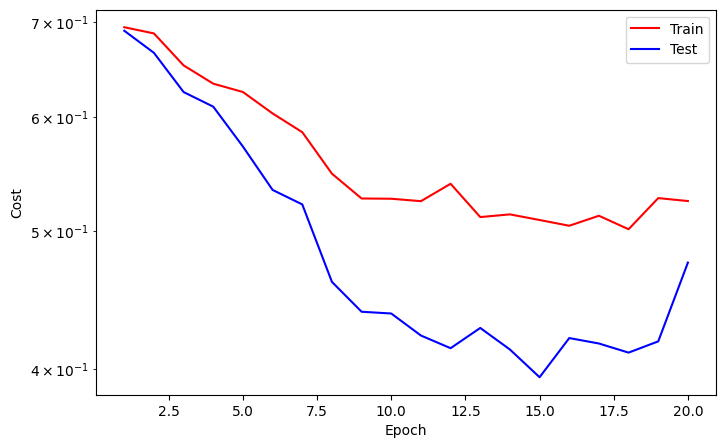

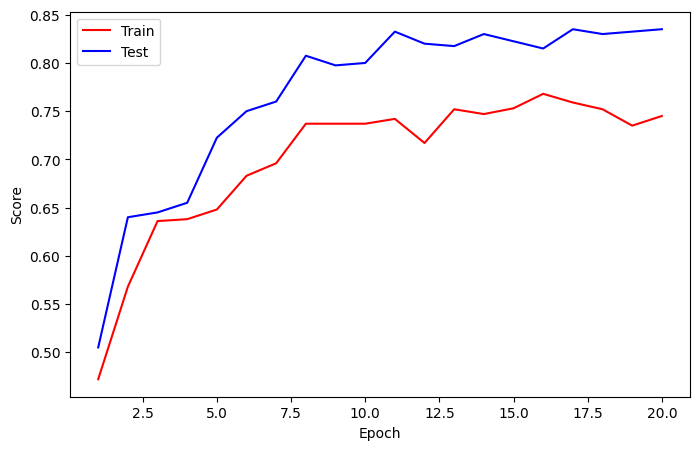

==> EarlyStop patience =  3 | Best test_score: 0.8350


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    21
Train_cost  = 0.5201 | Test_cost  = 0.4109 | Train_score = 0.7500 | Test_score = 0.8350 |
==> EarlyStop patience =  4 | Best test_score: 0.8350


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    22
Train_cost  = 0.5151 | Test_cost  = 0.4013 | Train_score = 0.7540 | Test_score = 0.8350 |
==> EarlyStop patience =  5 | Best test_score: 0.8350
==> Execute Early Stopping at epoch: 22 | Best test_score: 0.8350
==> Best model is saved at model


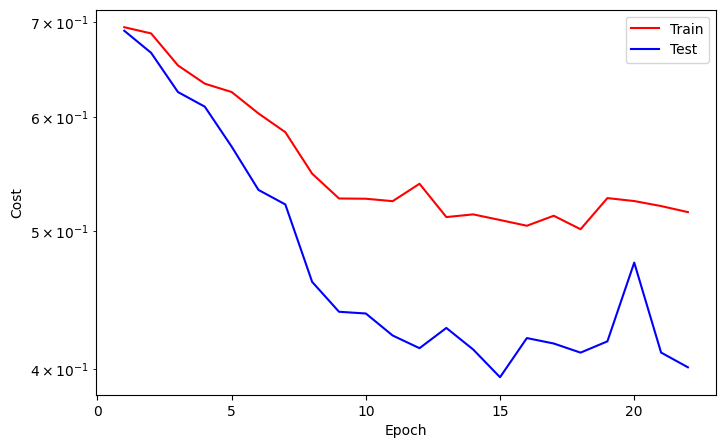

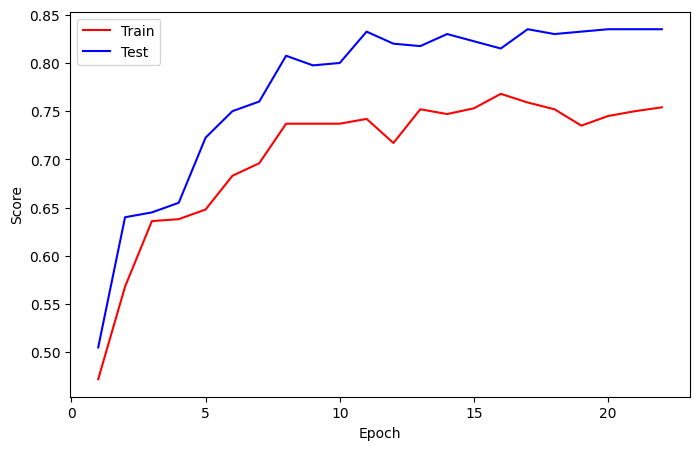

In [50]:
# Training dengan Accuracy
while True:
    train_cost, train_score = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost, test_score = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)

    # Logging
    callback.log(train_cost, test_cost, train_score, test_score)

    # Checkpoint
    callback.save_checkpoint()

    # Runtime Plotting
    callback.cost_runtime_plotting()
    callback.score_runtime_plotting()

    # Early Stopping
    if callback.early_stopping(model, monitor="test_score"):
        callback.plot_cost()
        callback.plot_score()
        break

# Predict

In [51]:
feature, target = next(iter(testloader))
feature, target = feature.to(device), target.to(device)

In [53]:
with torch.no_grad():
    model.eval()
    output = model(feature)
    preds = output.argmax(1)
[label2cat[pred] for pred in preds]

['invasive',
 'noninvasive',
 'noninvasive',
 'noninvasive',
 'invasive',
 'noninvasive',
 'invasive',
 'noninvasive',
 'invasive',
 'noninvasive',
 'noninvasive',
 'noninvasive',
 'noninvasive',
 'invasive',
 'noninvasive',
 'invasive',
 'noninvasive',
 'noninvasive',
 'noninvasive',
 'invasive',
 'noninvasive',
 'noninvasive',
 'invasive',
 'invasive',
 'noninvasive',
 'invasive',
 'noninvasive',
 'noninvasive',
 'noninvasive',
 'invasive',
 'noninvasive',
 'invasive',
 'noninvasive',
 'noninvasive',
 'noninvasive',
 'invasive',
 'invasive',
 'invasive',
 'invasive',
 'noninvasive',
 'invasive',
 'noninvasive',
 'noninvasive',
 'invasive',
 'noninvasive',
 'noninvasive',
 'noninvasive',
 'invasive',
 'noninvasive',
 'noninvasive',
 'invasive',
 'invasive',
 'invasive',
 'noninvasive',
 'noninvasive',
 'invasive',
 'invasive',
 'invasive',
 'invasive',
 'noninvasive',
 'invasive',
 'noninvasive',
 'invasive',
 'invasive',
 'noninvasive',
 'invasive',
 'invasive',
 'invasive',
 'noninv

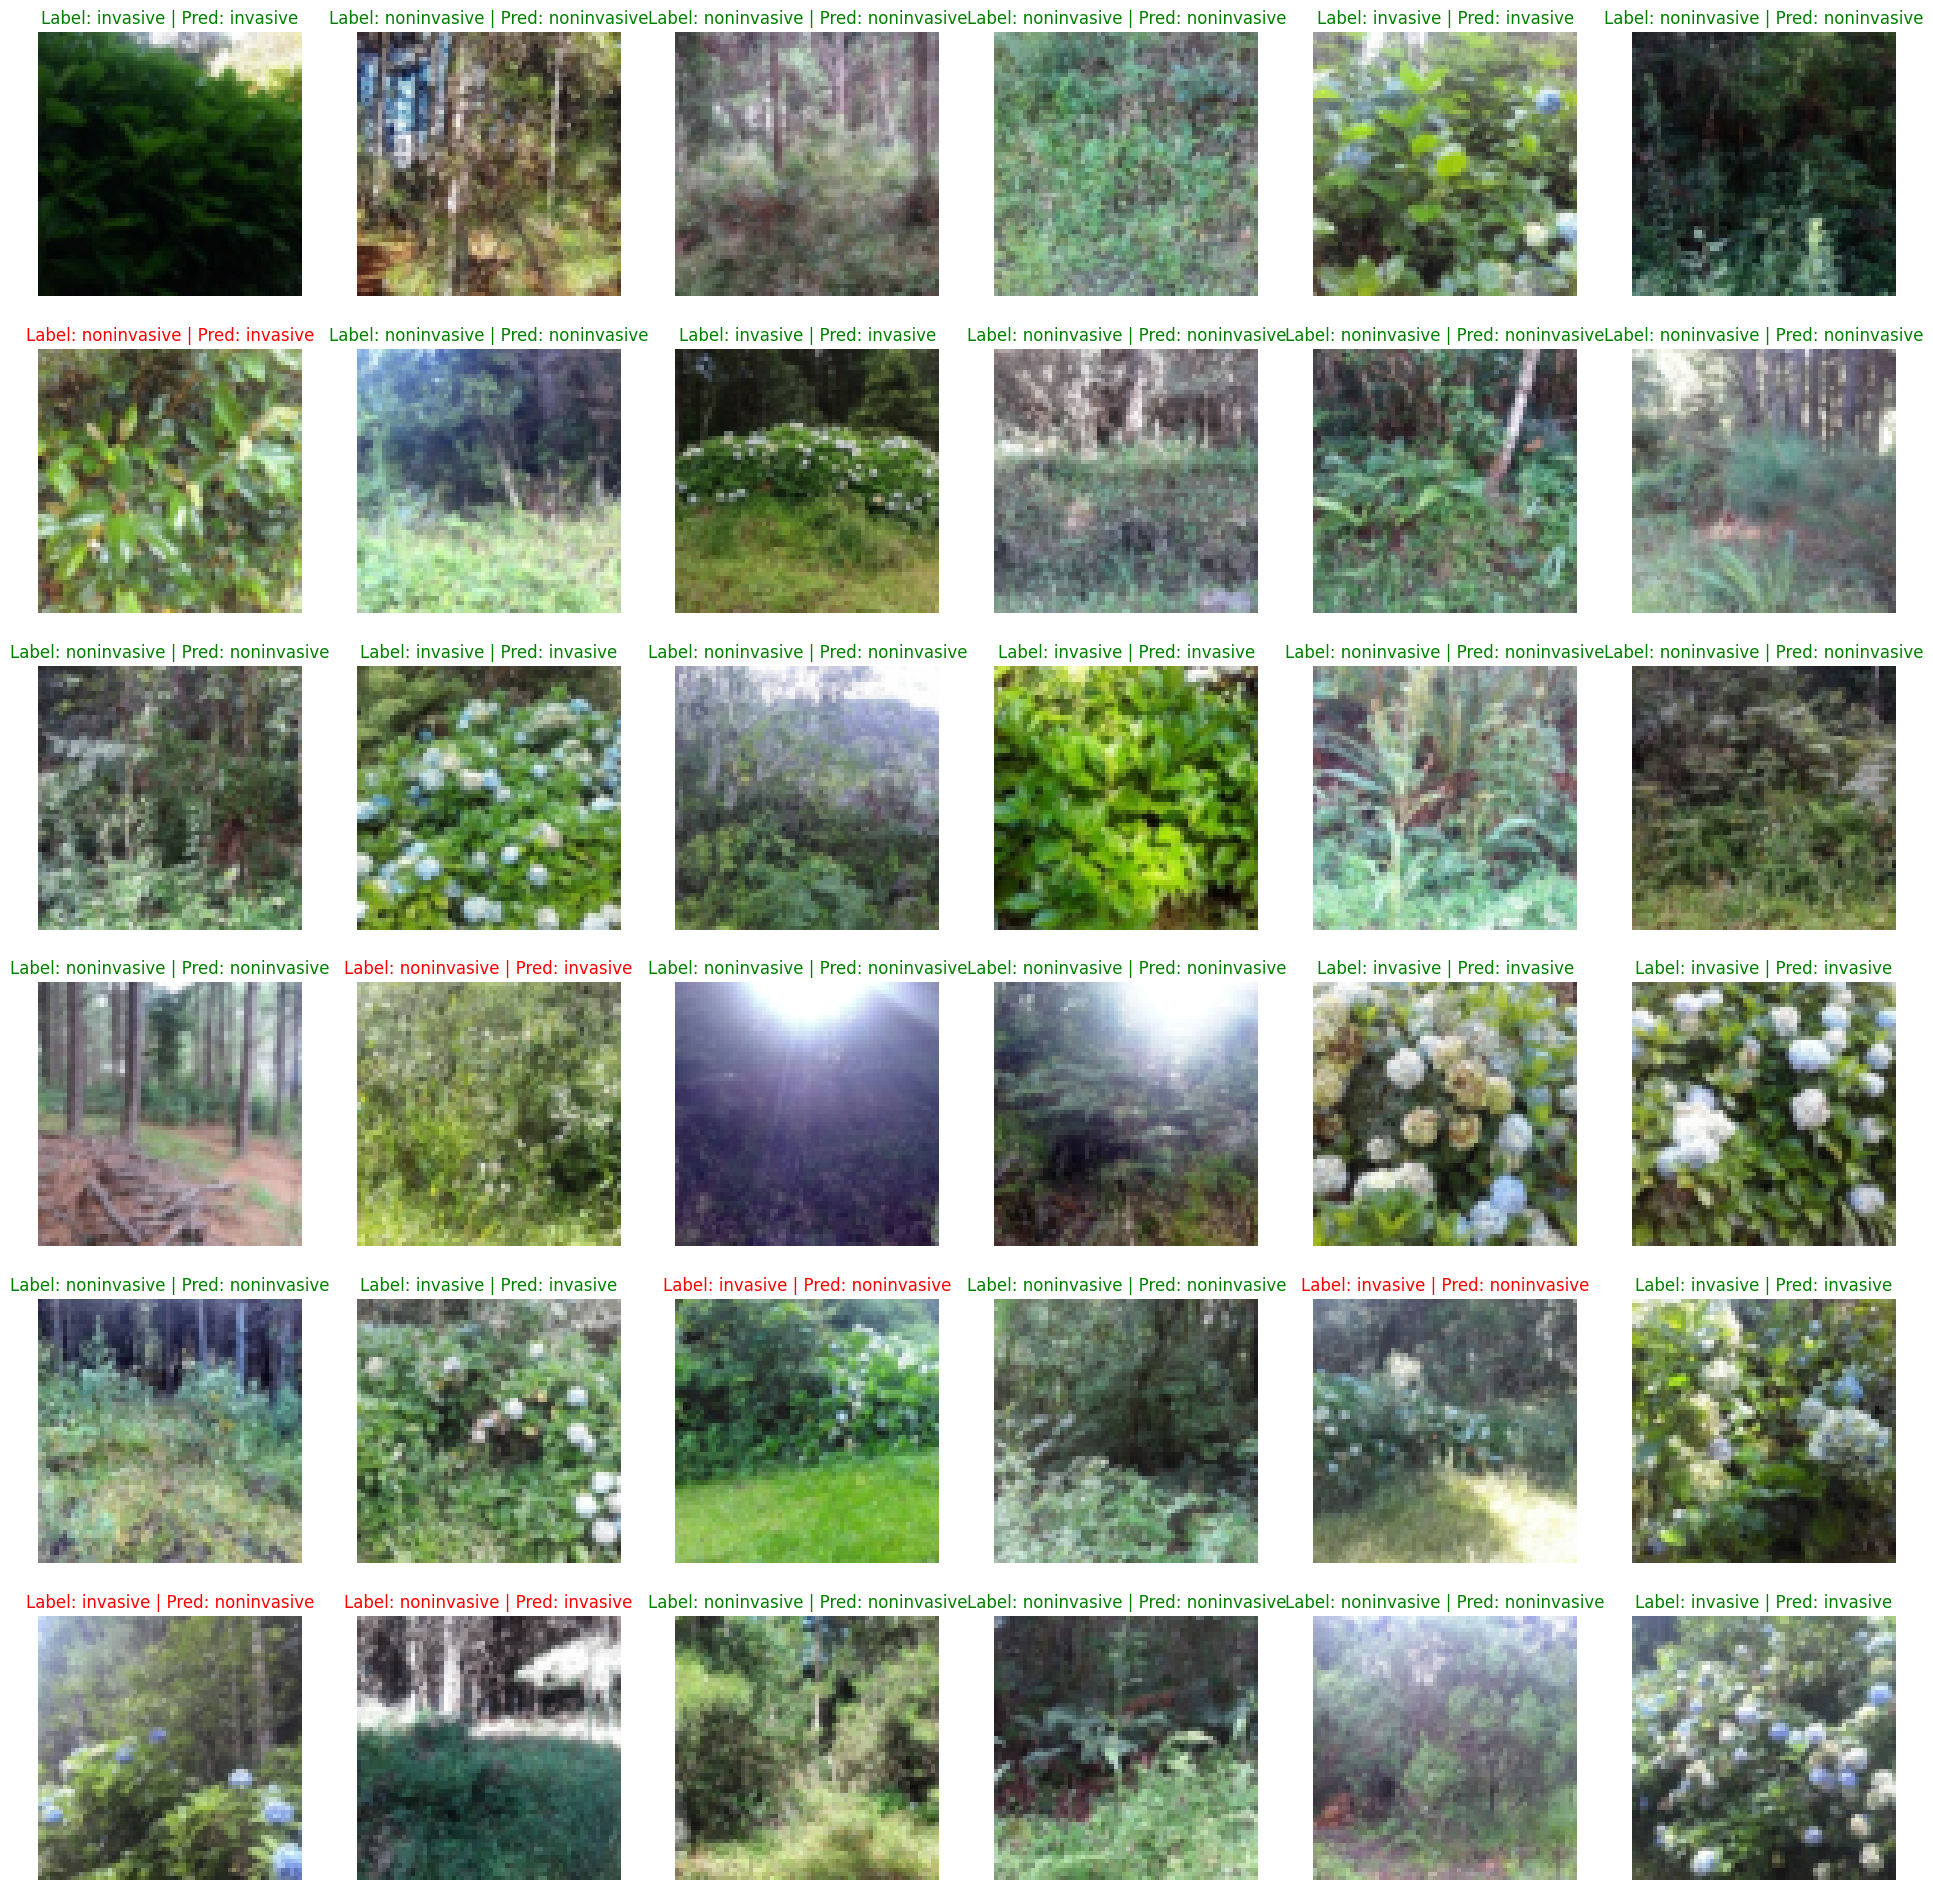

In [57]:
flg, axes = plt.subplots(6, 6, figsize=(24, 24))
for img, label, pred, ax in zip(feature, target, preds, axes.flatten()):
    ax.imshow(img.permute(1, 2, 0).cpu())  # Changed permute dimensions
    font = {"color": "r"} if label != pred else {"color": 'g'}
    label, pred = label2cat[label.item()], label2cat[pred.item()]
    ax.set_title(f"Label: {label} | Pred: {pred}", fontdict=font)
    ax.axis('off')